In [1]:
library(lpirfs)
library(gridExtra)
library(ggplot2)
library(readxl)
library(httr)

library(reshape2)
library(purrr) 

In [14]:
run_lp_model <- function(data, endog, exog, max_lags, newey_lags = NULL, horizons = 10, signif, lags_exog = NULL, cumulative = FALSE) {
  # Map confidence levels to the corresponding values
  confint_map <- c("0.05" = 1.96, "0.32" = 1)

  # Check if the provided significance level is valid
  if (!as.character(signif) %in% names(confint_map)) {
    stop("Invalid significance level. Use 0.05 for 95% or 0.32 for 68%.")
  }

  if (!is.null(exog)) {
    exog_data <- data[, exog, drop = FALSE]
    if (is.null(lags_exog)) {
        lags_exog = max_lags
    }
  } else {
    exog_data = NULL
  }

  # Select endogenous variables
  endog_data <- data[, endog, drop = FALSE]
  
  # Convert to numeric (ensure proper model fitting)
  endog_data <- data.frame(lapply(endog_data, as.numeric))
  
  # Run the local projections model
  results_lin <- lp_lin(
    endog_data, 
    exog_data = exog_data,
    lags_endog_lin = max_lags,  
    trend          = 0,  
    shock_type     = 1,  
    confint        = confint_map[as.character(signif)], 
    nw_lag         = newey_lags,
    hor            = horizons,
    lags_exog = lags_exog
  )

  title_text <- paste0(
    "LocalProjection ", 
    if (!is.null(exog)) "(with exog)" else "(without exog)", 
    if (cumulative) " - Cumulative" else "",
    " - signif ", 1-signif
  )

  plotlp(results_lin, endog = endog, title_text = title_text, cumulative = cumulative)
  
  # Process and print results with cumulative option
  pretty_results(results_lin = results_lin, endog_vars = endog, cumulative = cumulative)

  return(results_lin)
}

plotlp <- function(results_lin, endog, title_text, cumulative = FALSE) {
  if (cumulative) {
    for (i in 1:dim(results_lin$irf_lin_mean)[3]) {
      # Cumsum mean IRFs
      results_lin$irf_lin_mean[,,i] <- t(apply(results_lin$irf_lin_mean[,,i], 1, cumsum))
      
      # Cumsum error bands to match cumulative mean
      results_lin$irf_lin_low[,,i] <- t(apply(results_lin$irf_lin_low[,,i], 1, cumsum))
      results_lin$irf_lin_up[,,i]  <- t(apply(results_lin$irf_lin_up[,,i], 1, cumsum))
    }
  }

  # Generate plots
  linear_plots <- plot_lin(results_lin)

  print(title_text)
  
  # Show all plots
  lin_plots_all <- sapply(linear_plots, ggplotGrob)

  final_plot <- marrangeGrob(lin_plots_all, nrow = length(endog), ncol = length(endog), 
                             top = grid::textGrob(title_text, gp = grid::gpar(fontsize = 14, fontface = "bold")))

  print(final_plot)
}



pretty_results <- function(results_lin, endog_vars, cumulative = FALSE) {
  # Extract IRF values, lower and upper bounds
  irf_array <- results_lin$irf_lin_mean
  lower_bound_array <- results_lin$irf_lin_low
  upper_bound_array <- results_lin$irf_lin_up

  # Get dimensions
  dims <- dim(irf_array)
  n_endog <- dims[1]  # Number of endogenous variables (responses)
  n_horizons <- dims[2]  # Number of horizons
  n_impulses <- dims[3]  # Number of impulses

  # Create index grid
  indices <- expand.grid(
    impulse = 1:n_impulses,
    response = 1:n_endog,
    horizon = 1:n_horizons
  )

  # Flatten all arrays into vectors
  irf_values <- as.vector(irf_array)
  lower_values <- as.vector(lower_bound_array)
  upper_values <- as.vector(upper_bound_array)

  # Create dataframe
  irf_df <- data.frame(
    indices,
    irf_value = irf_values,
    lower_bound = lower_values,
    upper_bound = upper_values
  )

  # Exclude rows where impulse == response
  irf_df <- subset(irf_df, impulse != response)

  # Order by impulse, response, then horizon
  irf_df <- irf_df[order(irf_df$impulse, irf_df$response, irf_df$horizon), ]

  # Apply cumulative sum if needed
  if (cumulative) {
    irf_df <- irf_df %>%
      dplyr::group_by(impulse, response) %>%
      dplyr::mutate(
        irf_value = cumsum(irf_value),
        lower_bound = cumsum(lower_bound),
        upper_bound = cumsum(upper_bound)
      ) %>%
      dplyr::ungroup()
  }

  # Remove row names (drop index numbers)
  row.names(irf_df) <- NULL

  irf_df <- as.data.frame(irf_df)

  # Map impulse and response numbers to names
  irf_named_df <- irf_df
  irf_named_df$impulse <- endog_vars[irf_named_df$impulse]
  irf_named_df$response <- endog_vars[irf_named_df$response]

  # Split into a list of dataframes by impulse-response pair
  irf_list <- split(irf_named_df, list(irf_named_df$impulse, irf_named_df$response), drop = TRUE)

  # Print all dataframes in the list
  lapply(irf_list, print)
}


In [15]:
# Example of how to call the function
url <- "https://github.com/mbarrena/tesis/raw/refs/heads/main/data/Data%20trimestral%201950%20a%202023%20con%20DUMMIES%20outliers%20(por%20trimestre).xlsx"
temp_file <- tempfile(fileext = ".xlsx")
GET(url, write_disk(temp_file, overwrite = TRUE))

# Read the `data` from the Excel file
data <- read_excel(temp_file)

Response [https://raw.githubusercontent.com/mbarrena/tesis/refs/heads/main/data/Data%20trimestral%201950%20a%202023%20con%20DUMMIES%20outliers%20(por%20trimestre).xlsx]
  Date: 2025-03-23 16:51
  Status: 200
  Content-Type: application/octet-stream
  Size: 57.9 kB
<ON DISK>  /var/folders/59/6k0yx0n916gg1mdb04zs42rm0000gn/T//RtmpRBCV3x/file761e642436d2.xlsxNULL

[1] "LocalProjection (with exog) - signif 0.95"
     impulse response horizon     irf_value   lower_bound  upper_bound
23 ipc_ajust        E       1  3.929457e+01  3.929457e+01 3.929457e+01
24 ipc_ajust        E       2  1.559114e+01 -2.242167e+02 2.553989e+02
25 ipc_ajust        E       3  5.942546e+02  3.882707e+02 8.002385e+02
26 ipc_ajust        E       4  5.204582e+02 -3.111383e+02 1.352055e+03
27 ipc_ajust        E       5  2.486650e+00  1.937418e+00 3.035882e+00
28 ipc_ajust        E       6  3.446340e-01 -4.499525e+00 5.188793e+00
29 ipc_ajust        E       7  3.372366e+01  2.635332e+01 4.109400e+01
30 ipc_ajust        E       8  5.203546e+01  3.089377e+01 7.317716e+01
31 ipc_ajust        E       9 -7.101865e-04 -3.329971e-03 1.909598e-03
32 ipc_ajust        E      10  2.708612e-03 -9.095330e-04 6.326757e-03
33 ipc_ajust        E      11  6.964014e-04 -4.512973e-03 5.905775e-03
   impulse response horizon     irf_value   lower_bound  upper_bound
45   pbird        E       1  8.

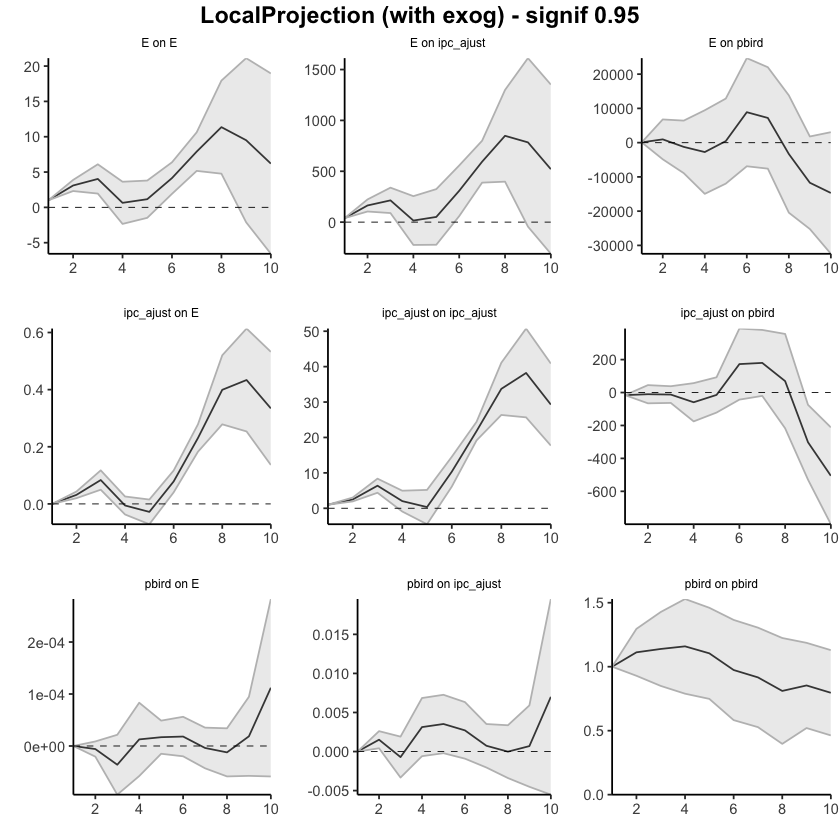

In [16]:
res <- run_lp_model(data, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 3, newey_lags = 4, signif = 0.05)

[1] "LocalProjection (with exog) - Cumulative - signif 0.95"
     impulse response horizon  irf_value lower_bound upper_bound
23 ipc_ajust        E       1   39.29457    39.29457    39.29457
24 ipc_ajust        E       2   54.88571  -184.92209   294.69351
25 ipc_ajust        E       3  649.14029   203.34857  1094.93201
26 ipc_ajust        E       4 1169.59849  -107.78973  2446.98670
27 ipc_ajust        E       5 1172.08514  -105.85231  2450.02259
28 ipc_ajust        E       6 1172.42977  -110.35184  2455.21138
29 ipc_ajust        E       7 1206.15343   -83.99852  2496.30538
30 ipc_ajust        E       8 1258.18889   -53.10475  2569.48254
31 ipc_ajust        E       9 1258.18818   -53.10808  2569.48445
32 ipc_ajust        E      10 1258.19089   -53.10899  2569.49077
33 ipc_ajust        E      11 1258.19159   -53.11350  2569.49668
   impulse response horizon   irf_value lower_bound upper_bound
45   pbird        E       1     81.7427     81.7427     81.7427
46   pbird        E       2  -2

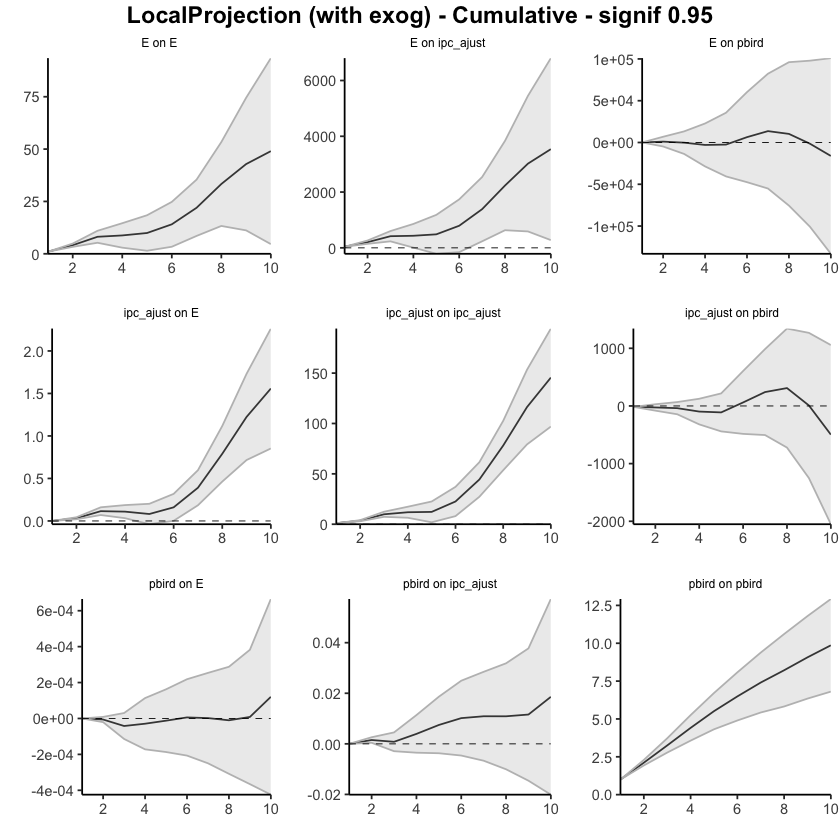

In [17]:
res <- run_lp_model(data, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 3, newey_lags = 4, signif = 0.05, cumulative=TRUE)
#run_lp_model(data, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 3, newey_lags = 4, signif = 0.32)
#run_lp_model(data, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 3, signif = 0.05)
#run_lp_model(data, endog=c("E", "ipc_ajust", "pbird"), exog=c("impp_usa"), max_lags = 3, signif = 0.32)
#run_lp_model(data, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, newey_lags = 4, signif = 0.05)
#run_lp_model(data, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, newey_lags = 4, signif = 0.32)
#run_lp_model(data, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, signif = 0.05)
#run_lp_model(data, endog=c("impp_usa", "E", "ipc_ajust", "pbird"), max_lags = 3, signif = 0.32)